In [112]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.stats import linregress
import seaborn as sns

sns.set_theme(style = 'ticks', palette = 'Blues')

In [113]:
# MODEL
def r_t(s, r_s, l_t, N, W, L):
    return (r_s * s / (N * W + (N-1) * (2 *s + L))) + (2 * r_s * l_t / (N * W + (N-1) * (2 *s + L)))

def line(x, m, b):
    return x * m + b

#Create model and parameters
gmodel5 = Model(r_t)
param5 = gmodel5.make_params()
param5['r_s'].set(value = 1e10, min = 0)
param5['l_t'].set(value = 1, min = 0)
param5['L'].set(value = 3200e-4, vary = False)
param5['W'].set(value = 5e-4, vary = False)
param5['N'].set(value = 60, vary = False)

[[Model]]
    Model(r_t)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 4
    # variables        = 2
    chi-square         = 1.9566e+10
    reduced chi-square = 9.7831e+09
    Akaike info crit   = 93.2431123
    Bayesian info crit = 92.0157010
    R-squared          = 0.99964076
##  Warning: uncertainties could not be estimated:
[[Variables]]
    r_s:  1.0368e+11 (init = 1e+10)
    l_t:  9.6712e-05 (init = 1)
    N:    60 (fixed)
    W:    0.0005 (fixed)
    L:    0.32 (fixed)
1.071698353428019e-06 530240.9097335265


c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1180: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\lopezb41\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\axes\_axes.py:1181: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


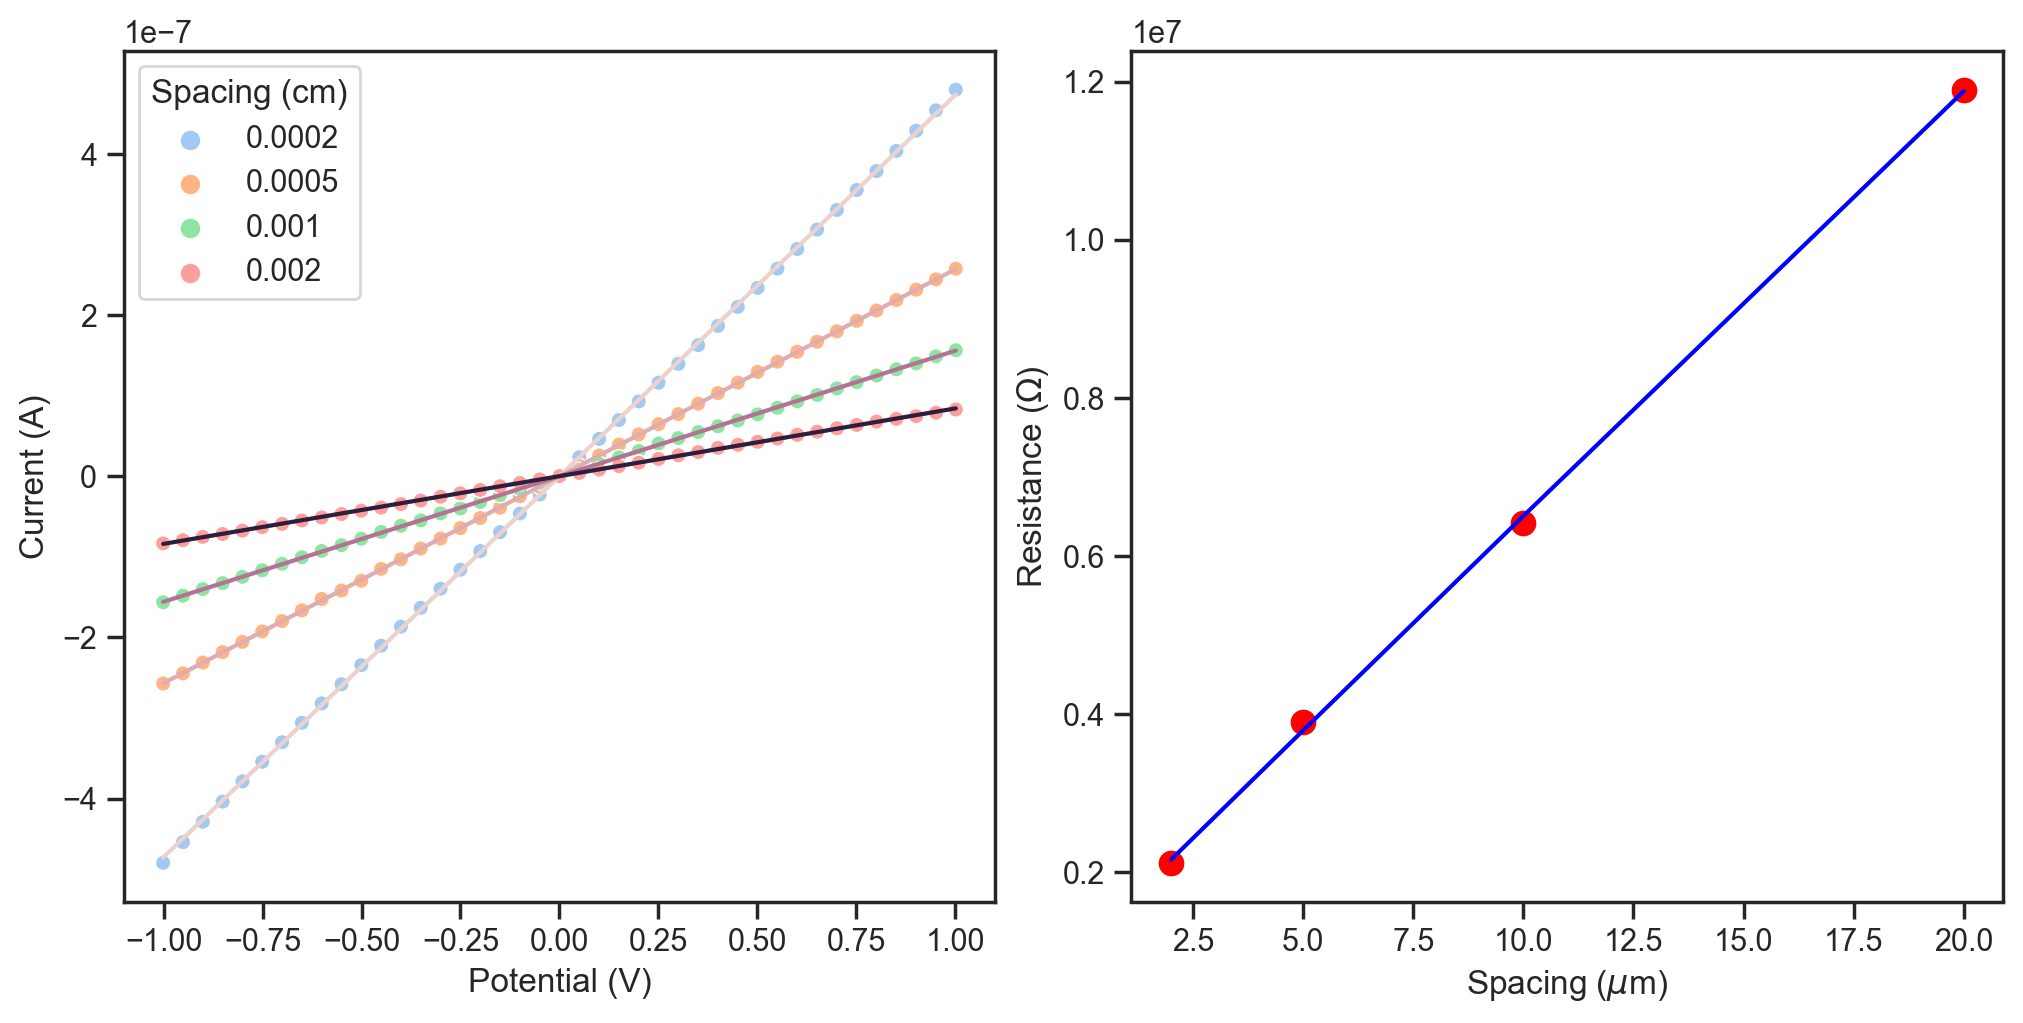

In [157]:
col = ['Potential (V)', 'Current (A)', 'Time (s)']
thickness = 90
path = r'C:\Users\lopezb41\OneDrive - imec\Documents\Experiments\Data\Contact Resistance\LSB_07\0G_25'
sample = path[-5:]
files = [os.path.join(path, i) for i in os.listdir(path)]
iv_fit = pd.DataFrame()
resistance = pd.DataFrame(columns = ['Spacing', 'Resistance'])

n = 0
for i in files:
    df = pd.read_csv(i, sep = ';', skiprows=1, names = col)
    slope, intercept, rvalue, pvalue, stderr = linregress(df[col[0]], df[col[1]])
    df['Fit (A)'] = line(df[col[0]], slope, intercept)

    if i[-5:-4] == '1':
        df['Spacing'] = 2e-4
        resistance.loc[n] = (2e-4, 1/slope)
    elif i[-5:-4] == '2':
        df['Spacing'] = 5e-4
        resistance.loc[n] = (5e-4, 1/slope)
    elif i[-5:-4] == '3':
        df['Spacing'] = 10e-4
        resistance.loc[n] = (10e-4, 1/slope)
    elif i[-5:-4] == '4':
        df['Spacing'] = 20e-4
        resistance.loc[n] = (20e-4, 1/slope)
    
    iv_fit = pd.concat([iv_fit, df])
    n += 1

spac = [2e-4, 5e-4, 10e-4, 20e-4]
average_df = pd.DataFrame()
for i in spac:
    df = resistance[resistance.Spacing == i].mean()
    average_df = pd.concat([average_df, df], axis=1) 
average_df = average_df.T.reset_index(drop = True)

# Contact resistance fit
result = gmodel5.fit(average_df['Resistance'], param5, s = average_df['Spacing'], fit_kws={"ftol":1e-22, "xtol":1e-22, "gtol":1e-22})
rs = result.values['r_s']
sigma = 1 / (rs * thickness * 1e-7)
rc = gmodel5.eval(result.params, s = 0)
print(result.fit_report())
print(sigma, rc/2)


# PLOT
fig, ax = plt.subplots(1,2, dpi = 200, figsize = (10,5), constrained_layout = True)
sns.scatterplot(data = iv_fit, x = col[0], y = col[1], s = 30, hue = 'Spacing', ax = ax[0], palette = sns.color_palette('pastel', n_colors=4))
sns.lineplot(data =iv_fit, x = col[0], y = 'Fit (A)', hue = 'Spacing', ax = ax[0], errorbar='sd', legend = False)
sns.lineplot(data = resistance, x = 'Spacing', y = 'Resistance',linestyle = '',  err_style='bars', marker = 'o', markersize = 10, ax = ax[1], color = 'r')
sns.lineplot(x = average_df['Spacing'], y = result.best_fit, color = 'b')


ax[1].xaxis.set_major_formatter(lambda x, pos: '{:.1f}'.format(x * 1e4))
ax[1].set_xlabel('Spacing ($\mu$m)')
ax[1].set_ylabel('Resistance ($\Omega$)')
ax[0].legend(title = 'Spacing (cm)')

In [115]:
# Scatch

    # if i[-10:-8] == 'C1':
    #     df['Column'] = 'C1'
    # elif i[-10:-8] == 'C2':
    #     df['Column'] = 'C2'
    # elif i[-10:-8] == 'C3':
    #     df['Column'] = 'C3'
    # elif i[-10:-8] == 'C4':
    #     df['Column'] = 'C4'